# DEVELOPER NOTE: Very rough draft

## DEVELOPER ACTION ITEMS:
- Improve on storyline/commentary throughout the notebook
- Revise code introduced in the notebook
    - Consider having small code tests for students to refer to
- Figure out estimated time for the notebook
- Integrate ipywidgets where possible!!!
- Use sign test for matched pairs for the Non-Parametric Tests part
- Add a lot of text! Most students are not familiar with code

## Timeline
- Finish almost final draft by next cycle

---

# ANOVA and Non-Parametric Tests

**Estimated Time**: ??? <br>
**Module Developer**: James Geronimo

## Table of Contents

1. Introduction <br>
    1.1. Learning Objectives <br>
    1.2. Understanding ANOVA <br>
    1.3. Setup
2. Data Preparation <br>
3. Visualizing the Data <br>
4. Performing ANOVA <br>
5. Sanity Check using SciPy <br>
6. Non-Parametric Test: Kruskal-Wallis Test <br>
7. Conclusion

---

## 1. Introduction

### 1.1. Learning Objectives

Understanding how to compare multiple groups statistically is crucial in data analysis. We will learn to apply **ANOVA** and **non-parametric tests** to analyze housing prices. In this notebook, you will:
- Understand when to use ANOVA instead of a two-mean test
- Learn how to manually compute ANOVA step-by-step
- Use SciPy’s `stats.f_oneway` as a sanity check
- Visualize housing price differences across different groups

### 1.2. Understanding ANOVA

What is the motivation for using **An**alysis **O**f **Va**riance, a.k.a. **ANOVA**, over a traditional Two-Mean Test? ANOVA is used when comparing **more than two groups**. More specfically, when comparing multiple groups, a series of two-sample t-tests is inefficient and increases the risk of Type I errors (false positives). ANOVA allows us to compare **more than two groups** in a single test. ANOVA checks whether the means of different groups are significantly different by comparing within-group and between-group variability.

We will explore **comparing house prices across different neighborhoods** in our dataset. There are a few assumptions that need to be made when running ANOVA tests:

1. **Normality:** The populations follow a normal distribution.
2. **Homogeneity of Variance:** Variances across groups are equal.
3. **Independence:** Observations are independent of each other.

### 1.3. Setup

Below, we have imported some Python libraries that are necessary for this module. Make sure to run this cell before running any other code cells!

In [42]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from ipywidgets import interact, widgets

---

## 2. Data Preparation

Let's first create a `DataFrame` for our data in a variable named `ames`. We do this by using the `read_csv` function from the `pandas` library. We then use `head(10)` to see the first 10 rows of the data. In other words, we view the "head" of the data.

In [43]:
# Load the dataset
ames = pd.read_csv("anova/AmesHousing.csv")
ames.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


Wow, that's a lot of columns to work with! We are only interested in two columns, namely, `"Neighborhood"` and `"SalePrice"`. Let's go ahead and index into these two columns and update our `ames` DataFrame.

In [44]:
# Select relevant columns
ames = ames[["Neighborhood", "SalePrice"]]
display(ames.head(10))
ames.shape

,Neighborhood,SalePrice
0,NAmes,215000
1,NAmes,105000
2,NAmes,172000
3,NAmes,244000
4,Gilbert,189900
5,Gilbert,195500
6,StoneBr,213500
7,StoneBr,191500
8,StoneBr,236500
9,Gilbert,189000


(2930, 2)

*COMMENTARY HERE* <br> . <br> .

In [28]:
# Filter neighborhoods with enough data
neighborhood_counts = ames["Neighborhood"].value_counts()
selected_neighborhoods = neighborhood_counts[neighborhood_counts > 50].index

ames = ames[ames["Neighborhood"].isin(selected_neighborhoods)]
ames

,Neighborhood,SalePrice
0,NAmes,215000
1,NAmes,105000
2,NAmes,172000
3,NAmes,244000
4,Gilbert,189900
...,...,...
2925,Mitchel,142500
2926,Mitchel,131000
2927,Mitchel,132000
2928,Mitchel,170000


---

## 3. Visualizing the Data

Before conducting statistical tests, visualizations help us understand the distribution and variance of data across different neighborhoods.

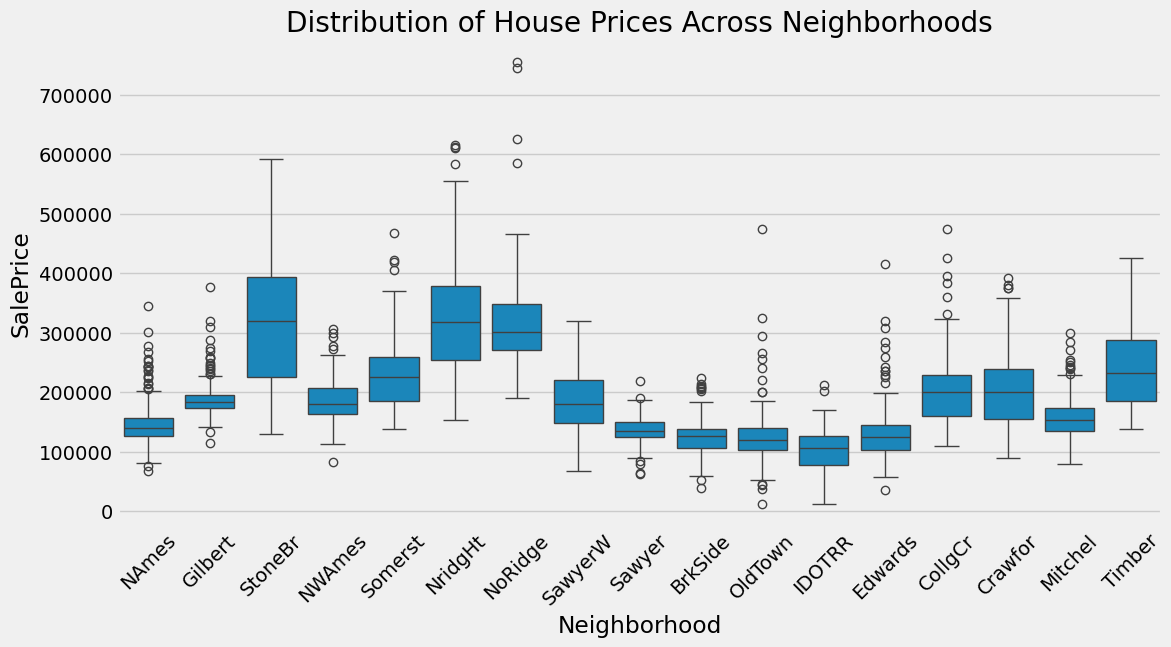

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=ames, x="Neighborhood", y="SalePrice")
plt.xticks(rotation=45)
plt.title("Distribution of House Prices Across Neighborhoods")
plt.show()

---

## 4. Performing ANOVA

We will first try manually computing ANOVA. This will allow us to gain a deeper understanding of its components, in contrast to using a built-in function.

In [45]:
# Step 1: Compute Group Means and Overall Mean
group_means = ames.groupby("Neighborhood")["SalePrice"].mean()
overall_mean = ames["SalePrice"].mean()

# Step 2: Compute Between-Group Sum of Squares (SSB)
ssb = sum(ames.groupby("Neighborhood").size() * (group_means - overall_mean) ** 2)

# Step 3: Compute Within-Group Sum of Squares (SSW)
ssw = sum(sum((ames[ames["Neighborhood"] == group]["SalePrice"] - group_mean) ** 2)
          for group, group_mean in group_means.items())

# Step 4: Compute Degrees of Freedom
ames_between = len(group_means) - 1
ames_within = len(ames) - len(group_means)

# Step 5: Compute Mean Squares
msb = ssb / ames_between
msw = ssw / ames_within

# Step 6: Compute F-Statistic
f_statistic = msb / msw

# Step 7: Find p-value
p_value = 1 - stats.f.cdf(f_statistic, ames_between, ames_within)

print(f"F-statistic: {f_statistic:.2f}, p-value: {p_value:.5f}")

F-statistic: 144.40, p-value: 0.00000


---

## 5. Sanity Check Using SciPy

Now that we have computed the F-statistic for ANOVA manually, let us use a pre-packaged function from `SciPy` called `f_oneway` to sanity check our results.

In [46]:
anova_result = stats.f_oneway(*[ames[ames["Neighborhood"] == n]["SalePrice"] for n in selected_neighborhoods])
print(f"Sanity Check - SciPy F-statistic: {anova_result.statistic:.2f}, p-value: {anova_result.pvalue:.5f}")

Sanity Check - SciPy F-statistic: 215.65, p-value: 0.00000


---

## 6. Non-Parametric Test: Kruskal-Wallis Test

Let us say that the original assumptions we made at the beginning of the notebook were false. This would be a problem, as our results from the ANOVA test would then be invalid! Let us use the Kruskal-Wallis Test, which is a non-parametric test that compares median differences.

In [47]:
kruskal_result = stats.kruskal(*[ames[ames["Neighborhood"] == n]["SalePrice"] for n in selected_neighborhoods])
print(f"Kruskal-Wallis Test Statistic: {kruskal_result.statistic:.2f}, p-value: {kruskal_result.pvalue:.5f}")

Kruskal-Wallis Test Statistic: 1601.06, p-value: 0.00000


---

## 7. Conclusion

Given our p-values in both cases were under 0.05, we reject the null hypothesis. This indicatessignificant price differences between neighborhoods. 

Note, however, that we should have more rigorously proved the ANOVA assumptions to be true at the start of the notebook, though this was abstracted away for the sake of this notebook.

We also applied the Kruskal-Wallis Test, which proves as a useful Non-Paramteric Test when the assumptions regarding normality and equal variance are violated for ANOVA.

We encourage you to explore further with the groundwork laid out with this notebook. You can try running ANOVA on different features and explore more tests to determine what neighborhoods had more signficant differences in sale price against other neighborhoods.

---

**Woohoo! You have completed this notebook! 🚀**|